# DaKanjiRecognizer - Single Kanji CNN : Training

## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import time
import datetime

#ML
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

#creating one hot encodings
#from sklearn.preprocessing import LabelBinarizer

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

Because the data sets are big let's make sure that the GPU is available to speed up training.

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


If a GPU with native 16 bit float support (ex.: RTX-series) is available, enable support for it here.

In [43]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.mixed_precision.set_global_policy("mixed_float16")

## Setting up the Data pipeline

Read the labels for each class from file.

In [150]:
labels_1, labels_2, labels = [], [], []

# load labels from file
with open(r'F:\data_sets\etlcdb\encoding_1.txt', mode="r", encoding="utf-8") as f:
    labels_1 = list(eval(f.read()).keys())
with open(r'F:\data_sets\etlcdb\encoding_2.txt', mode="r", encoding="utf-8") as f:
    labels_2 = list(eval(f.read()).keys())

ls = labels_1 + labels_2
# order the labels
indexs = sorted([str(i) for i in range(0, len(ls))])
ordered_labels = [ls[int(i)] for i in indexs]

# save the labels to text files
with open(r'E:\projects\DaKanjiRecognizerML\single_kanji_cnn\labels_python_list.txt', mode="w+", encoding="utf-8") as f:
    f.write(str(ordered_labels))
with open(r'E:\projects\DaKanjiRecognizerML\single_kanji_cnn\labels.txt', mode="w+", encoding="utf-8") as f:  
    f.write(''.join(ordered_labels))

Create a `tf.keras.dataset` from the saved files for test and validation.

In [5]:
#batch size
bs=512
# class names
classes = ["%04d" % i for i in range(len(labels))]

In [6]:
#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

## create train dataset

In [49]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'F:\data_sets\etlcdb',
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="grayscale",
    batch_size=bs,
    image_size=(64, 64),
    validation_split=0.15,
    subset="training",
    seed=123
)

Found 6731099 files belonging to 6543 classes.
Using 5721435 files for training.


In [91]:
train = train_dataset.map(
    lambda x, y : (tf.cast(x, tf.float16), (tf.cast(y, tf.float16))),
    num_parallel_calls=tf.data.AUTOTUNE
)
train = train.cache(r"F:\data_sets\etlcdb_cache\cache_train")
train = train.shuffle(buffer_size=bs*3)
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

print(train.take(0))

<TakeDataset shapes: ((None, 64, 64, 1), (None, 6543)), types: (tf.float16, tf.float16)>


## create test dataset

In [51]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'F:\data_sets\etlcdb',
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="grayscale",
    batch_size=bs,
    image_size=(64, 64),
    validation_split=0.15,
    subset="validation",
    seed=123
)

Found 6731099 files belonging to 6543 classes.
Using 1009664 files for validation.


In [52]:
val = val_dataset.map(
    lambda x, y : (tf.cast(x, tf.float16), (tf.cast(y, tf.float16))),
    num_parallel_calls=tf.data.AUTOTUNE
)
val = val.cache(r"F:\data_sets\etlcdb_cache\cache_test")
val = val.shuffle(buffer_size=bs*3)
val = val.prefetch(buffer_size=tf.data.AUTOTUNE)

print(val.take(0))

<TakeDataset shapes: ((None, 64, 64, 1), (None, 6543)), types: (tf.float16, tf.float16)>


## Defining and training the CNN

In [74]:
def get_model(name : str):
    _model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(input_shape=(64, 64, 1), kernel_size=3, activation='relu', filters=32, name="conv2D_1_2_input"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2d_1_1"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_1"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2d_2_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2d_2_2"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_2"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2d_3_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2d_3_2"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_3"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=128, name="conv2d_4_1"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_4"),

        tf.keras.layers.Flatten(name="flatten_1"),
        tf.keras.layers.Dropout(0.25, name="dropout_1"),
        
        tf.keras.layers.Dense(512, name="dense_1"),
        tf.keras.layers.Dropout(0.25, name="dropout_2"),

        tf.keras.layers.Dense(512, name="dense_2"),
        tf.keras.layers.Dropout(0.25, name="dropout_3"),
        
        tf.keras.layers.Dense(512, name="dense_3"),
        tf.keras.layers.Dropout(0.25, name="dropout_4"),

        tf.keras.layers.Dense(len(labels), name="dense_4"),

        #set the dtype to float32 for numerical stability
        tf.keras.layers.Softmax(dtype="float32", name="softmax_1_output") 
    ], name=name)
    
    return _model


f16_model = get_model("DaKanjiRecognizer_f16")
print(f16_model.output_shape)
f16_model.summary()

(None, 6543)
Model: "DaKanjiRecognizer_f16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1_2_input (Conv2D)    (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1_1 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2_1 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2_2 (Conv2D)          (None, 26, 26, 32)        9248      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3_1 (Conv2D)          (No

In [75]:
#path where the model should be saved
model_dir = os.path.join(os.getcwd(), "model")
print("model_dir:", model_dir)

model_dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model


Set the optimizer, loss function and compile the model

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)

f16_model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
#optionally load stored weights to resume training
#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-145-0.98.hdf5"))

In [77]:
#checkpoints setup
filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

print("checkpoints dir:", filepath)

checkpoints dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5


Optionally enable tensorboard to track the progress of the model.

In [78]:
# load the tensorboard extension
%load_ext tensorboard

# add the tensorboard callback
log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list.append(tensorboard_callback)

#set the path to the tensorboard executable
#%env TENSORBOARD_BINARY E:\\projects\\DaKanjiRecognizerML\\.venv\\Scripts\\tensorboard.exe
#%tensorboard --logdir log_dir

print("tensorboard log dir:", log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
tensorboard log dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\logs\20210607-220920


Finally train the model on the data set (in case of an Interrupt creates checkpoints).

In [79]:
#train the model
hist = f16_model.fit(
    train,
    validation_data=val,
    epochs=100,
    initial_epoch=50,
    workers=16,
    use_multiprocessing=True,
    callbacks=callbacks_list
)

Epoch 51/100
11175/11175 [==============================] - 184s 16ms/step - loss: 6.7200 - accuracy: 0.0405 - val_loss: 3.9112 - val_accuracy: 0.2591

Epoch 00051: val_accuracy improved from -inf to 0.25914, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-51-0.26.hdf5
Epoch 52/100
11175/11175 [==============================] - 179s 16ms/step - loss: 3.8649 - accuracy: 0.2399 - val_loss: 2.2763 - val_accuracy: 0.5483

Epoch 00052: val_accuracy improved from 0.25914 to 0.54825, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-52-0.55.hdf5
Epoch 53/100
11175/11175 [==============================] - 177s 16ms/step - loss: 2.7848 - accuracy: 0.4115 - val_loss: 1.7012 - val_accuracy: 0.6628

Epoch 00053: val_accuracy improved from 0.54825 to 0.66276, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-53-0.66.hdf5
Epoch 54/1

Epoch 77/100
11175/11175 [==============================] - 168s 15ms/step - loss: 0.9871 - accuracy: 0.7790 - val_loss: 0.6106 - val_accuracy: 0.8850

Epoch 00077: val_accuracy improved from 0.88059 to 0.88502, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-77-0.89.hdf5
Epoch 78/100
11175/11175 [==============================] - 167s 15ms/step - loss: 0.9799 - accuracy: 0.7812 - val_loss: 0.6186 - val_accuracy: 0.8839

Epoch 00078: val_accuracy did not improve from 0.88502
Epoch 79/100
11175/11175 [==============================] - 168s 15ms/step - loss: 0.9687 - accuracy: 0.7834 - val_loss: 0.6120 - val_accuracy: 0.8860

Epoch 00079: val_accuracy improved from 0.88502 to 0.88598, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-79-0.89.hdf5
Epoch 80/100
11175/11175 [==============================] - 167s 15ms/step - loss: 0.9618 - accuracy: 0.7849 - val_loss: 0.6135 - v

## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

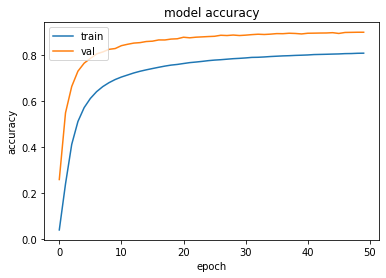

In [80]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The graphs look good.
Let's now make a prediction.

['ゆ', 'ゅ', '屮', '幼', '衂', '四', '叨', '血', '甥', 'め']


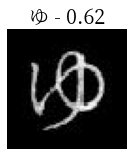

In [191]:
sample = tf.keras.preprocessing.image.load_img(
    path= r"F:\data_sets\etlcdb\0100\10.jpg",
    color_mode="grayscale"
)
sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = sample.reshape((1, 64, 64, 1))

# output 10 most liekly predictions
prediction = f16_model.predict(sample)[0]
ind = np.argpartition(prediction, -10)[-10:]
q = ind[np.argsort(prediction[ind])]
print([ordered_labels[i] for i in reversed(q)])

show_image(sample.reshape((64, 64)), ordered_labels[prediction.argmax()] + " - %.2f" % prediction.max())

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.pb" file.

In [56]:
f16_model.save(os.path.join(model_dir, "tf", "trained_model"))

INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\trained_model\assets


INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\trained_model\assets


In [47]:
# Create a float32 model with the same weights as the mixed_float16 model, so
# that it loads into TF Lite
policy = tf.keras.mixed_precision.global_policy()
tf.keras.mixed_precision.set_global_policy("float32")
f32_model = get_model("DaKanjiRecognizer_f32")
f32_model.set_weights(f16_model.get_weights())
#f32_model.summary()
tf.keras.mixed_precision.set_global_policy(policy)

Finally convert the model to a TF-Light model to be used in other applications ([DaKanjiRecognizer Desktop](https://github.com/CaptainDario/DaKanjiRecognizer-Desktop))

In [39]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(f32_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(model_dir, "tflite", "model.tflite"), 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmp0_8ibwdm\assets


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmp0_8ibwdm\assets
